###  Time Series Analysis and Forecasting of Exchange Traded Fund (ETF) using Python

#### Srilakshmi Bodduluru

#### DSC-680

In [1]:
# loading all the required libraries
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

In [2]:
# load data
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('GLD.csv',sep=',', index_col='Date', parse_dates=['Date'], date_parser=dateparse).fillna(0)

In [3]:
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


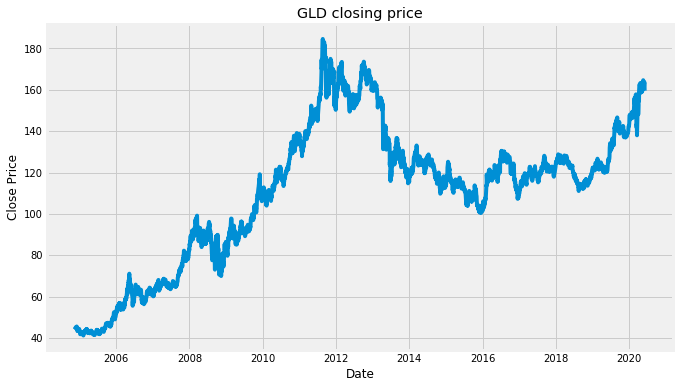

In [4]:
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.plot(data['Close'])
plt.title('GLD closing price')
plt.show()

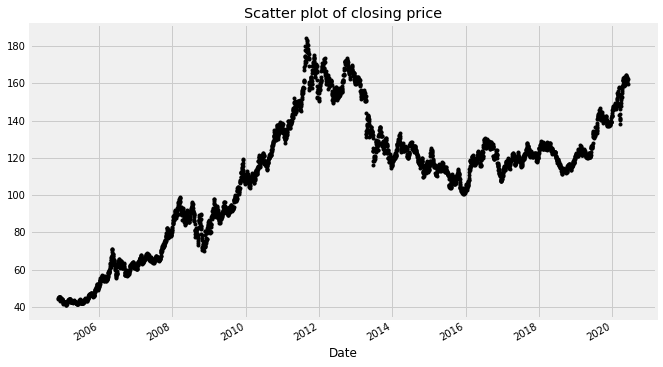

In [5]:
# Lets us plot the scatterplot:
plt.figure(figsize=(10,6))
df_close = data['Close']
df_close.plot(style='k.')
plt.title('Scatter plot of closing price')
plt.show()

First, we need to check if a series is stationary or not because time series analysis only works with stationary data.

ADF (Augmented Dickey-Fuller) Test:

The Dickey-Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test is:

Null Hypothesis: The series has a unit root (value of a =1)

Alternate Hypothesis: The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.
If both mean and standard deviation are flat lines(constant mean and constant variance), the series becomes stationary.

So let's check for stationarity:

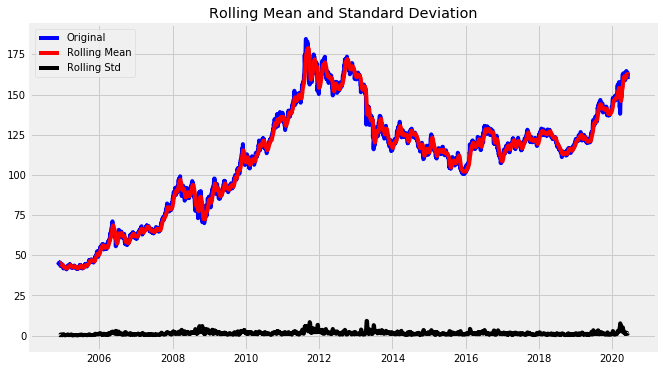

Results of dickey fuller test
Test Statistics                  -1.556895
p-value                           0.505202
No. of lags used                  0.000000
Number of observations used    3910.000000
critical value (1%)              -3.432024
critical value (5%)              -2.862279
critical value (10%)             -2.567164
dtype: float64


In [6]:
#Test for staionarity
plt.figure(figsize=(10,6))
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)   
    
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(df_close)

Through the above graph, we can see the increasing mean and standard deviation and hence our series is not stationary.

We see that the p-value is greater than 0.05 so we cannot reject the Null hypothesis. Also, the test statistics is greater than the critical values. so the data is non-stationary.

In order to perform a time series analysis, we may need to separate seasonality and trend from our series. The resultant series will become stationary through this process.

So let us separate Trend and Seasonality from the time series.

<Figure size 432x288 with 0 Axes>

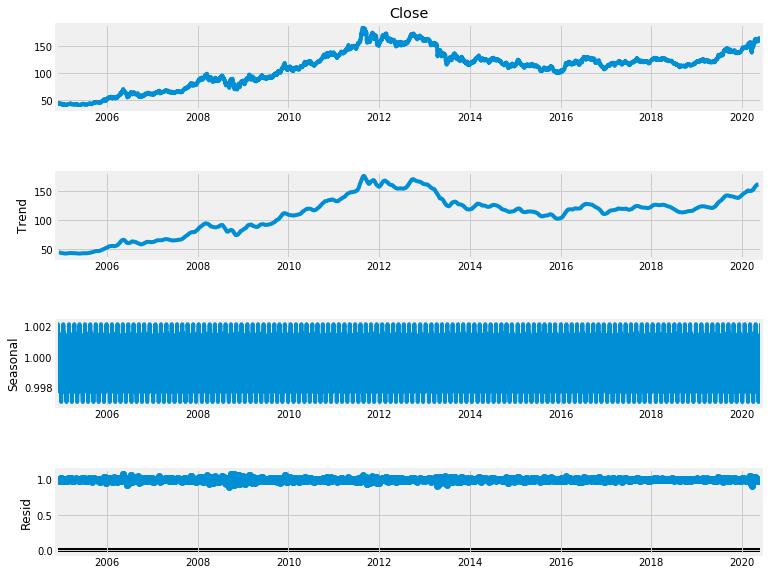

In [7]:
#To separate the trend and the seasonality from a time series, we can decompose the series using the following code.
result = seasonal_decompose(df_close, model='multiplicative', freq = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(12, 9)

we start by taking a log of the series to reduce the magnitude of the values and reduce the rising trend in the series. Then after getting the log of the series, we find the rolling average of the series.
A rolling average is calculated by taking input for the past 12 months and giving a mean consumption value at every point further ahead in series.

No handles with labels found to put in legend.


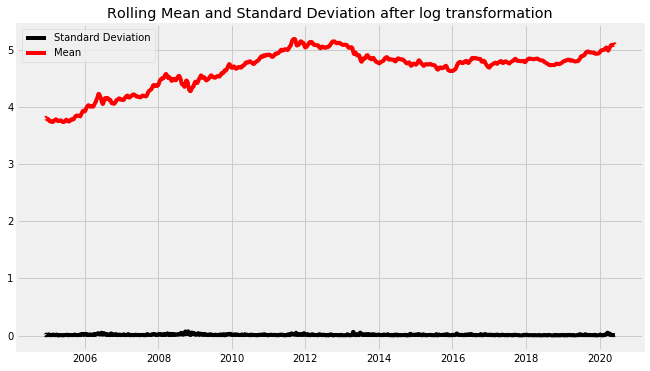

In [8]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Rolling Mean and Standard Deviation after log transformation')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

Now we are going to create an ARIMA model and will train it with the closing price of the stock on the train data. So let us split the data into training and test set and visualize it.

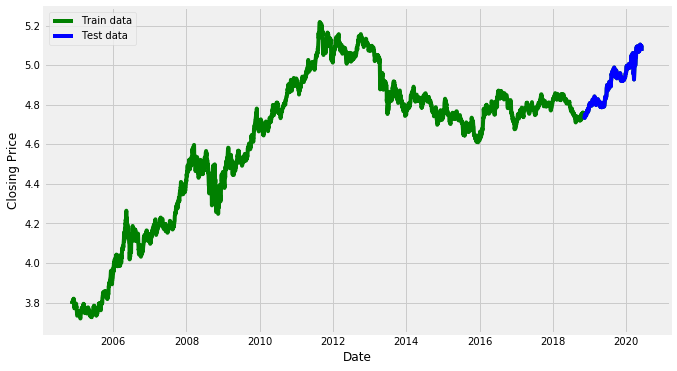

In [9]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

### Auto ARIMA:

Its time to choose parameters p,q,d for ARIMA model. we are going to use Auto ARIMA to get the best parameters without even plotting ACF and PACF graphs.
Auto ARIMA: Automatically discover the optimal order for an ARIMA model.

The auto_arima function seeks to identify the most optimal parameters for an ARIMA model, and returns a fitted ARIMA model. This function is based on the commonly-used R function, forecast::auto.arima.

In [10]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-21276.635, BIC=-21264.305, Time=0.245 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-21276.283, BIC=-21257.788, Time=0.187 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-21276.300, BIC=-21257.806, Time=0.485 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-21276.765, BIC=-21270.600, Time=0.120 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=-21274.341, BIC=-21249.681, Time=1.132 seconds
Total fit time: 2.180 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3516
Model:               SARIMAX(0, 1, 0)   Log Likelihood               10639.382
Date:                Wed, 29 Jul 2020   AIC                         -21276.765
Time:                        15:54:07   BIC                         -21270.600
Sample:                             0   HQIC       

So the Auto ARIMA model provided the value of p,d, and q as 0,1 and 0 respectively.
Before moving forward, let’s review the residual plots from auto ARIMA.

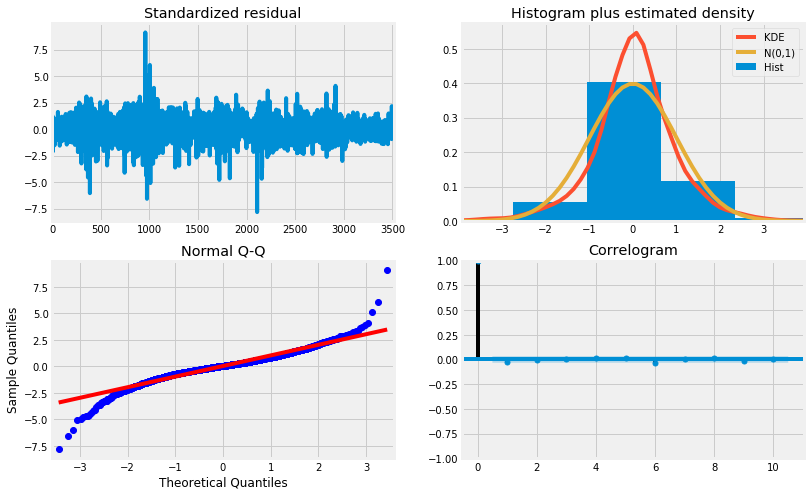

In [11]:
model_autoARIMA.plot_diagnostics(figsize=(12,8))
plt.show()

So how to interpret the plot diagnostics?
Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance.
Top Right: The density plot suggest normal distribution with mean zero.
Bottom left: All the dots should fall perfectly in line with the red line. Any significant deviations would imply the distribution is skewed.
Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated. Any autocorrelation would imply that there is some pattern in the residual errors which are not explained in the model. So you will need to look for more X’s (predictors) to the model.
Overall, it seems to be a good fit. Let’s start forecasting the stock prices.
Next, create an ARIMA model with provided optimal parameters p, d and q.

In [12]:
import warnings
warnings.filterwarnings('ignore')
model = ARIMA(train_data, order=(0, 1, 0))  
fitted = model.fit(disp=-1)  
print(fitted.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3515
Model:                 ARIMA(0, 1, 0)   Log Likelihood               10640.317
Method:                           css   S.D. of innovations              0.012
Date:                Wed, 29 Jul 2020   AIC                         -21276.635
Time:                        15:54:08   BIC                         -21264.305
Sample:                             1   HQIC                        -21272.235
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.000      1.368      0.171      -0.000       0.001


Now let's start forecast the stock prices on the test dataset keeping 95% confidence level.

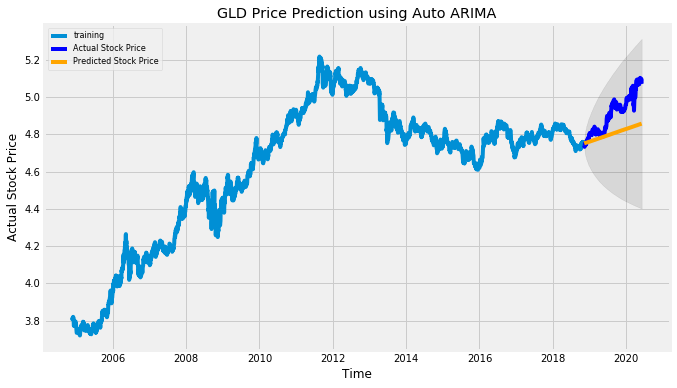

In [13]:
# Forecast
fc, se, conf = fitted.forecast(392, alpha=0.05)  # 95% confidence
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf[:, 0], index=test_data.index)
upper_series = pd.Series(conf[:, 1], index=test_data.index)
plt.figure(figsize=(10,6))
plt.plot(train_data, label='training')
plt.plot(test_data, color = 'blue', label='Actual Stock Price')
plt.plot(fc_series, color = 'orange',label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.10)
plt.title('GLD Price Prediction using Auto ARIMA')
plt.xlabel('Time')
plt.ylabel('Actual Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

As you can see our model performed quite well. Let us also check the commonly used accuracy metrics to judge forecast results:

In [14]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 0.016070746854602705
MAE: 0.10513033888128652
RMSE: 0.12677044945334345
MAPE: 0.021132228271523917


Around 2.1% MAPE(Mean Absolute Percentage Error) implies the model is about 97.9% accurate in predicting the test set
observations.

In [15]:
#read the file
df = pd.read_csv('GLD.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2004-11-18,44.430000,44.490002,44.070000,44.380001,44.380001,5992000
1,2004-11-19,44.490002,44.919998,44.470001,44.779999,44.779999,11655300
2,2004-11-22,44.750000,44.970001,44.740002,44.950001,44.950001,11996000
3,2004-11-23,44.880001,44.919998,44.720001,44.750000,44.750000,3169200
4,2004-11-24,44.930000,45.049999,44.790001,45.049999,45.049999,6105100


In [16]:
#setting index as date values
df['Date'] = pd.to_datetime(df.Date,format='%Y-%m-%d')
df.index = df['Date']

#sorting
data = df.sort_index(ascending=True, axis=0)

data['Close_orig'] = data['Close'] # to save a copy of the original data

# log-transform y
data['Close'] = np.log(data['Close'])
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_orig
Date,,,,,,,,
2004-11-18,2004-11-18,44.430000,44.490002,44.070000,3.792789,44.380001,5992000,44.380001
2004-11-19,2004-11-19,44.490002,44.919998,44.470001,3.801762,44.779999,11655300,44.779999
2004-11-22,2004-11-22,44.750000,44.970001,44.740002,3.805551,44.950001,11996000,44.950001
2004-11-23,2004-11-23,44.880001,44.919998,44.720001,3.801091,44.750000,3169200,44.750000
2004-11-24,2004-11-24,44.930000,45.049999,44.790001,3.807773,45.049999,6105100,45.049999


In [17]:
#creating a separate dataset
new_data = pd.DataFrame(index=range(0,len(df)),columns=['Date', 'Close'])

for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['Close'][i]


In [18]:
new_data.shape
new_data.head()

,Date,Close
0,2004-11-18 00:00:00,3.79279
1,2004-11-19 00:00:00,3.80176
2,2004-11-22 00:00:00,3.80555
3,2004-11-23 00:00:00,3.80109
4,2004-11-24 00:00:00,3.80777


#### Prophet

There are a number of time series techniques that can be implemented on the stock prediction dataset, but most of these techniques require a lot of data preprocessing before fitting the model. Prophet, designed and pioneered by Facebook, is a time series forecasting library that requires no data preprocessing and is extremely simple to implement. The input for Prophet is a dataframe with two columns: date and target (ds and y).

Prophet tries to capture the seasonality in the past data and works well when the dataset is large.

In [19]:
#importing prophet
from fbprophet import Prophet
pd.plotting.register_matplotlib_converters()

new_data['Date'] = pd.to_datetime(new_data.Date,format='%Y-%m-%d')
new_data.index = new_data['Date']

#preparing data
new_data.rename(columns={'Close': 'y', 'Date': 'ds'}, inplace=True)

In [20]:
new_data.head()

,ds,y
Date,,
2004-11-18,2004-11-18,3.79279
2004-11-19,2004-11-19,3.80176
2004-11-22,2004-11-22,3.80555
2004-11-23,2004-11-23,3.80109
2004-11-24,2004-11-24,3.80777


In [21]:
#train and validation
train = new_data[:3500]
valid = new_data[3500:]

#fit the model
model = Prophet()
model.fit(train)

#predictions
close_prices = model.make_future_dataframe(periods=len(valid))
forecast = model.predict(close_prices)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [22]:
len(valid)

411

In [23]:
#rmse
forecast_valid = forecast['yhat'][3500:]
rms_prophet=np.sqrt(np.mean(np.power((np.array(valid['y'])-np.array(forecast_valid)),2)))
rms_prophet

0.13053034282448692

In [24]:
type(forecast_valid)

pandas.core.series.Series

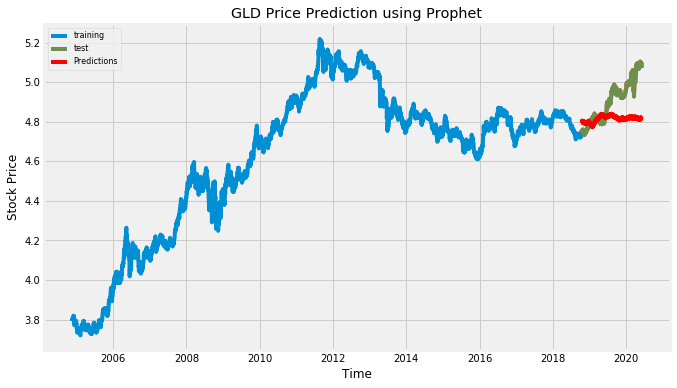

In [25]:
#plot
plt.figure(figsize=(10,6))
valid['Predictions'] = 0
valid['Predictions'] = forecast_valid.values
plt.title('GLD Price Prediction using Prophet')
plt.plot(train['y'],label='training')
plt.plot(valid[['y', 'Predictions']])
plt.plot(valid['y'], label = 'test')
plt.plot(valid['Predictions'], label = 'Predictions', color = 'red')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)

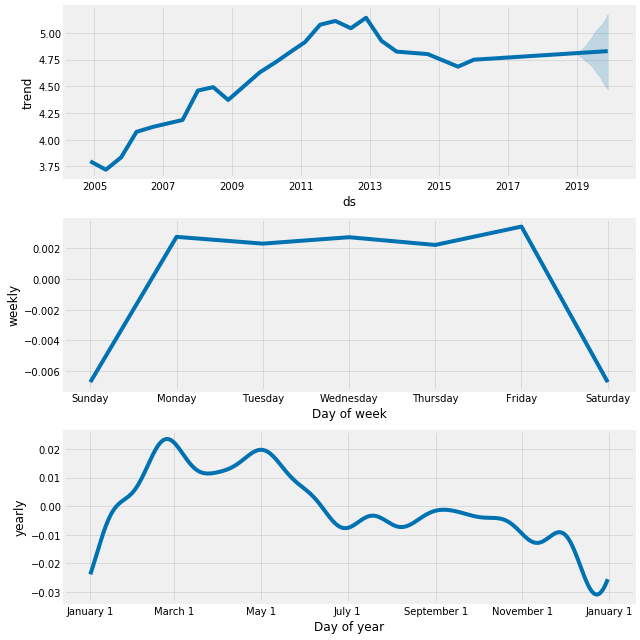

In [26]:
model.plot_components(forecast);

The trend shows an increase in the ETF price with time which is good. Also, the closing price is almost constant from Monday to Friday. Deeper dip during week ends is due to holidays. Gold ETF price is more during the first half of the year compared to second half.

In [27]:
print("rmse of prophet Model:",math.sqrt(mean_squared_error(valid['y'],forecast_valid)))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('rmse of AutoARIMA model: '+str(rmse))


rmse of prophet Model: 0.13053034282448694
rmse of AutoARIMA model: 0.12677044945334345


Prophet (like most time series forecasting techniques) tries to capture the trend and seasonality from past data. This model usually performs well on time series datasets, but fails to live up to it’s reputation in this case.

As it turns out, stock prices do not have a particular trend or seasonality. It highly depends on what is currently going on in the market and thus the prices rise and fall. Hence forecasting techniques like ARIMA and Prophet would not show good results for this particular problem.

## Comparison of Different Algorithms

In [28]:
df = pd.read_csv('GLD.csv') # read csv file

df['Close_orig'] = df['Close'] # to save a copy of the original data..you'll see why shortly. 

# log-transform y
df['Close'] = np.log(df['Close'])
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Close_orig
0,2004-11-18,44.430000,44.490002,44.070000,3.792789,44.380001,5992000,44.380001
1,2004-11-19,44.490002,44.919998,44.470001,3.801762,44.779999,11655300,44.779999
2,2004-11-22,44.750000,44.970001,44.740002,3.805551,44.950001,11996000,44.950001
3,2004-11-23,44.880001,44.919998,44.720001,3.801091,44.750000,3169200,44.750000
4,2004-11-24,44.930000,45.049999,44.790001,3.807773,45.049999,6105100,45.049999


In [29]:
df.shape

(3911, 8)

In [30]:
rows = df.values.tolist()  # convert dataframe into a list

In [31]:
from sklearn.model_selection import train_test_split
x_train = []
y_train = []
x_test = []
y_test = []
X = []
Y = []
for row in rows:
    X.append(int(''.join(row[0].split('-'))))
    Y.append(row[4])
x_train, x_test, y_train, y_test = train_test_split(X,Y,train_size=0.9,test_size=0.1) # split training and test data

# Convert lists into numpy arrays 
x_train = np.array(x_train)
y_train = np.array(y_train)
x_test = np.array(x_test)
y_test = np.array(y_test)

# reshape the values as we have only one input feature
x_train = x_train.reshape(-1,1)
x_test = x_test.reshape(-1,1)

In [32]:
len(x_train)

3519

In [33]:
# Linear Regression model
from sklearn.linear_model import LinearRegression 
clf_lr = LinearRegression()
clf_lr.fit(x_train,y_train)
y_pred_lr = clf_lr.predict(x_test)

# Support Vector Machine with a Radial Basis Function as kernel 
from sklearn.svm import SVR
clf_svr = SVR(kernel='rbf', C=1e3, gamma=0.1)
clf_svr.fit(x_train,y_train)
y_pred_svr = clf_svr.predict(x_test)

# Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
clf_rf = RandomForestRegressor(n_estimators=100)
clf_rf.fit(x_train,y_train)
y_pred_rf = clf_rf.predict(x_test)

# Gradient Boosting Regressor
from sklearn.ensemble import GradientBoostingRegressor
clf_gb = GradientBoostingRegressor(n_estimators=200)
clf_gb.fit(x_train,y_train)
y_pred_gb = clf_gb.predict(x_test)

In [34]:
type(y_pred_lr)

numpy.ndarray

Using the subplot feature, we plot the multiple predicted values from different models to visualise how good our algorithms can predict the values.

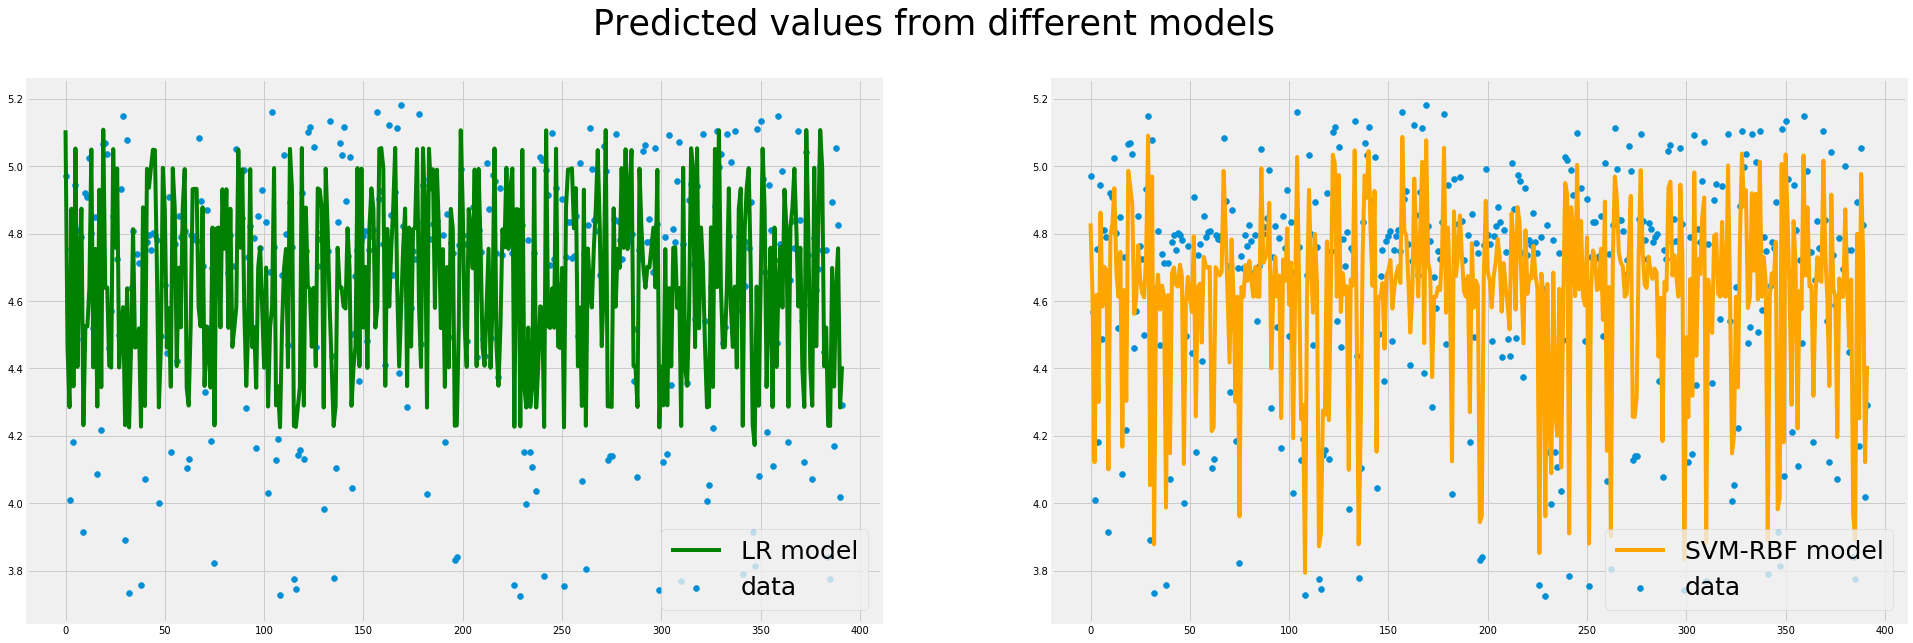

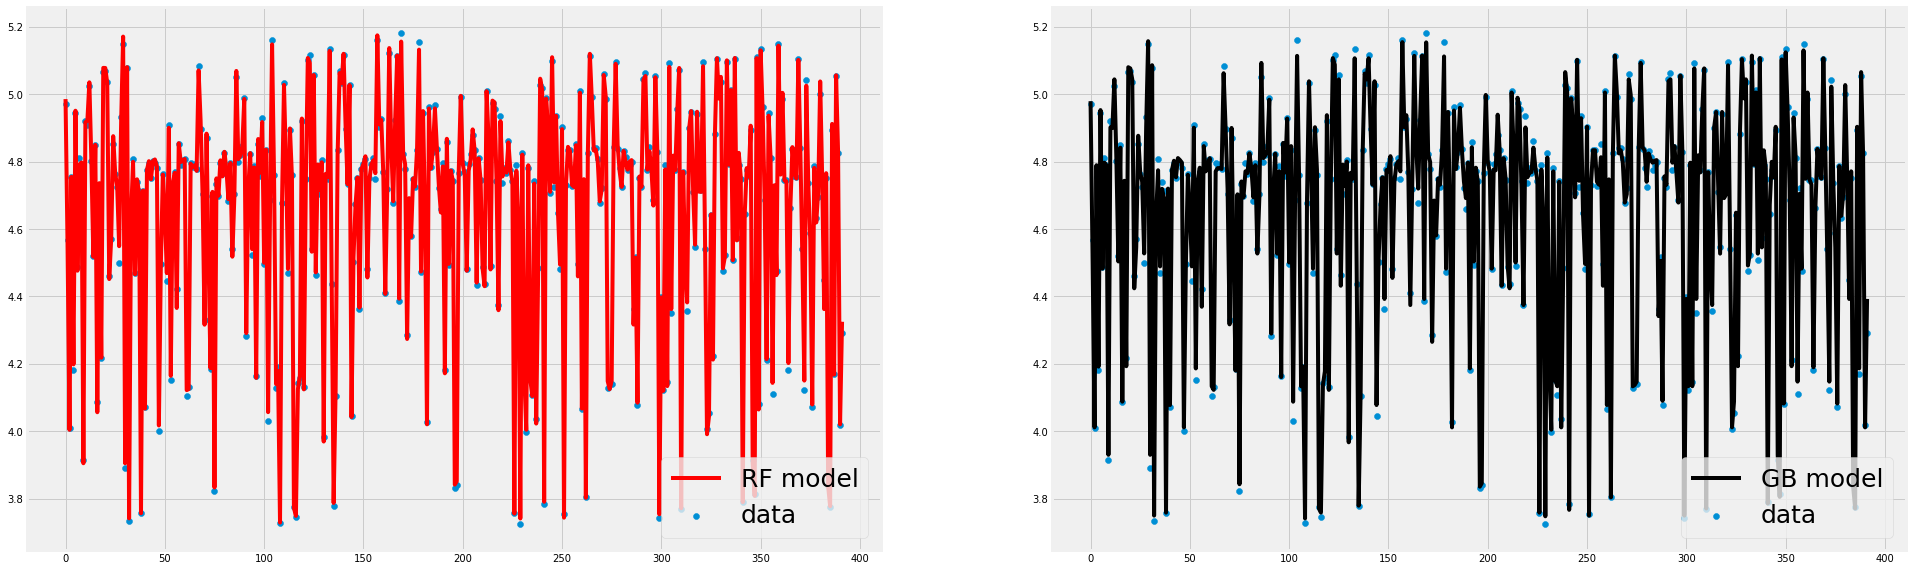

In [35]:
import matplotlib.pyplot as plt 

f,(ax1,ax2) = plt.subplots(1,2,figsize=(30,10))
f.suptitle('Predicted values from different models', size = 35)

# Linear Regression
ax1.scatter(range(len(y_test)),y_test,label='data')
ax1.plot(range(len(y_test)),y_pred_lr,color='green',label='LR model')
ax1.legend(loc='lower right',prop={'size': 25})


# Support Vector Machine
ax2.scatter(range(len(y_test)),y_test,label='data')
ax2.plot(range(len(y_test)),y_pred_svr,color='orange',label='SVM-RBF model')
ax2.legend(loc='lower right',prop={'size': 25})

f1,(ax3,ax4) = plt.subplots(1,2,figsize=(30,10))

# Random Forest Regressor
ax3.scatter(range(len(y_test)),y_test,label='data')
ax3.plot(range(len(y_test)),y_pred_rf,color='red',label='RF model')
ax3.legend(loc='lower right',prop={'size': 25})

# Gradient Boosting Regressor
ax4.scatter(range(len(y_test)),y_test,label='data')
ax4.plot(range(len(y_test)),y_pred_gb,color='black',label='GB model')
ax4.legend(loc='lower right',prop={'size': 25})

From the above plots you can observe that linear regression has been the worst performing model of all, it failed to predict the correct values a considerable number of times compared to other algorithms.

In [36]:
print("Accuracy of Linear Regerssion Model:",clf_lr.score(x_test,y_test))
print("Accuracy of SVM-RBF Model:",clf_svr.score(x_test,y_test))
print("Accuracy of Random Forest Model:",clf_rf.score(x_test,y_test))
print("Accuracy of Gradient Boosting Model:",clf_gb.score(x_test,y_test))

Accuracy of Linear Regerssion Model: 0.4901386193761791
Accuracy of SVM-RBF Model: 0.9073904335233454
Accuracy of Random Forest Model: 0.9987844305384143
Accuracy of Gradient Boosting Model: 0.9973171743145923


In [37]:
from sklearn.metrics import mean_squared_error
print("rmse of Linear Regerssion Model:",math.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("rmse of SVM-RBF Model:",math.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("rmse of Random Forest Model:",math.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("rmse of Gradient Boosting Model:",math.sqrt(mean_squared_error(y_test, y_pred_gb)))

rmse of Linear Regerssion Model: 0.24929763075221034
rmse of SVM-RBF Model: 0.10624781754548861
rmse of Random Forest Model: 0.012172561648971637
rmse of Gradient Boosting Model: 0.018083742740009803


As you can see, the random forest regressor is the best model to use out of all four. Gradient Boosting comes a close second but since every percentage matters, as it could mean earning more money, random forest regressor is the model to go for.

In [38]:
print("rmse of prophet Model:",math.sqrt(mean_squared_error(valid['y'],forecast_valid)))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('rmse of AutoARIMA model: '+str(rmse))
print("rmse of Linear Regerssion Model:",math.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("rmse of SVM-RBF Model:",math.sqrt(mean_squared_error(y_test, y_pred_svr)))
print("rmse of Random Forest Model:",math.sqrt(mean_squared_error(y_test, y_pred_rf)))
print("rmse of Gradient Boosting Model:",math.sqrt(mean_squared_error(y_test, y_pred_gb)))

rmse of prophet Model: 0.13053034282448694
rmse of AutoARIMA model: 0.12677044945334345
rmse of Linear Regerssion Model: 0.24929763075221034
rmse of SVM-RBF Model: 0.10624781754548861
rmse of Random Forest Model: 0.012172561648971637
rmse of Gradient Boosting Model: 0.018083742740009803
